In [1]:
import casadi
from casadi import *
import numpy

from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
rc('animation', html='jshtml')

# Dark mode plots ;)

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

from ipywidgets import IntProgress
from IPython.display import display

## Dynamics

This defines the non-linear dynamics: $f(x, u) = \dot x$


In [2]:
g = 9.8
m = 100000 # kg
min_thrust = 880 * 1000 # N
max_thrust = 1 * 2210 * 1000 #kN

length = 50 # m 
width = 10

# Inertia for a uniform density rod 
I = (1/12) * m * length**2

deg_to_rad = 0.01745329

max_gimble = 20  * deg_to_rad
min_gimble = -max_gimble

# x[0] = x position (m)
# x[1] = x velocity (m/)
# x[2] = y position (m)
# x[3] = y velocity (m/s)
# x[4] = angle (rad)
# x[5] = angular velocity (rad/s)

# u[0] = thrust (percent)
# u[1] = thrust angle (rad)

def x_dot(x, u):
    theta = x[4]
    
    thrust = u[0]
    thrust_angle = u[1]
    
    # Horizontal force
    F_x = max_thrust * thrust * sin(thrust_angle + theta)
    x_dot = x[1]
    x_dotdot = (F_x) / m
        
    # Vertical force
    F_y = max_thrust * thrust * cos(thrust_angle + theta)
    y_dot = x[3]
    y_dotdot = (F_y) / m - g
    
    # Torque
    T = -length/2 * max_thrust * thrust * sin(thrust_angle)
    theta_dot = x[5]
    theta_dotdot = T / I
    
    return [x_dot, x_dotdot, y_dot, y_dotdot, theta_dot, theta_dotdot]

## Optimization problem

Sets up and runs the trajectory optimization problem

In [4]:
# Make an optimization problem
opti = casadi.Opti()

# Set the number of steps and the timestep (dt)
steps = 400
t_step = 0.04

# Generate the array of state and control vectors
x = opti.variable(steps, 6)
u = opti.variable(steps, 2)
# t_step = opti.variable(1, 1)

# opti.subject_to( opti.bounded(0.01, t_step, 0.2))

x[0, :] = [0, 0, 1000, -80, -np.pi/2, 0]
x[steps-1, :] = [0, 0, 0, 0, 0, 0]

# u[steps-1, 1] = 0

# Cost function
opti.minimize(sumsqr(u[:, 0]) +  sumsqr(u[:, 1]) + 2 * sumsqr(x[:, 5]))

# Set dynamics constraints
for i in range(0, steps-1):
    opti.subject_to( x[i+1, 0] - x[i, 0] == x_dot(x[i, :], u[i, :])[0] * t_step )
    opti.subject_to( x[i+1, 1] - x[i, 1] == x_dot(x[i, :], u[i, :])[1] * t_step )
    
    opti.subject_to( x[i+1, 2] - x[i, 2] == x_dot(x[i, :], u[i, :])[2] * t_step )
    opti.subject_to( x[i+1, 3] - x[i, 3] == x_dot(x[i, :], u[i, :])[3] * t_step )
    
    opti.subject_to( x[i+1, 4] - x[i, 4] == x_dot(x[i, :], u[i, :])[4] * t_step )
    opti.subject_to( x[i+1, 5] - x[i, 5] == x_dot(x[i, :], u[i, :])[5] * t_step )

# Set bounds constraints
for i in range(0, steps):
    opti.subject_to( opti.bounded(0.4, u[i, 0], 1))
    opti.subject_to( opti.bounded(min_gimble, u[i, 1], max_gimble))

# Select solver
opti.solver('ipopt')

# Solve! Might take ~ 20 seconds
sol = opti.solve()

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     9160
Number of nonzeros in inequality constraint Jacobian.:      800
Number of nonzeros in Lagrangian Hessian.............:     2791

Total number of variables............................:     3200
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2394
Total number of inequality constraints...............:      800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.97e+02 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 1.6587418e+02 8.96e+02 9.99e+02   3.0 0.00e+00   2.8 0.00e+00 4.33e-07R  4
  91r 1.6476689e+02 8.96e+02 9.99e+02   3.0 6.71e+04    -  7.92e-05 8.85e-06f  1
  92r 1.7266398e+02 8.76e+02 9.71e+02   0.9 6.89e+02    -  8.57e-02 2.82e-02f  1
  93r 1.7648329e+02 8.62e+02 9.51e+02   0.9 7.11e+02    -  1.58e-02 2.04e-02f  1
  94r 1.7942779e+02 8.62e+02 8.84e+02   0.9 3.32e+00   2.0 3.25e-01 9.46e-02f  1
  95r 1.8038207e+02 8.57e+02 8.77e+02   0.9 6.02e+02    -  2.54e-02 8.15e-03f  1
  96r 1.8259348e+02 8.46e+02 8.62e+02   0.9 6.05e+02    -  4.08e-04 1.78e-02f  1
  97r 1.9003194e+02 8.14e+02 8.10e+02   0.9 5.32e+02    -  7.30e-02 6.02e-02f  1
  98r 2.0018624e+02 8.12e+02 4.92e+02   0.9 3.54e+00   1.5 2.37e-01 4.90e-01f  1
  99r 2.0142675e+02 8.03e+02 5.11e+02   0.9 2.75e+02    -  1.66e-02 3.53e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.0148606e+02 8.03e+02

 182r 1.8087068e+02 7.31e+02 2.69e+01  -0.6 1.07e+00   1.4 7.37e-01 2.38e-01f  1
 183r 1.8107899e+02 7.31e+02 2.72e+01  -0.6 3.90e-01   1.8 9.73e-01 4.62e-01f  1
 184r 1.8138063e+02 7.31e+02 2.60e+01  -0.6 1.12e+00   1.3 4.91e-01 2.47e-01f  1
 185r 1.8162029e+02 7.31e+02 2.93e+01  -0.6 4.15e-01   1.7 1.00e+00 4.75e-01f  1
 186r 1.8193994e+02 7.31e+02 3.18e+01  -0.6 1.23e+00   1.3 5.41e-01 2.04e-01f  1
 187r 1.8214106e+02 7.31e+02 3.42e+01  -0.6 4.50e-01   1.7 1.00e+00 4.07e-01f  1
 188r 1.8250128e+02 7.31e+02 3.38e+01  -0.6 1.29e+00   1.2 4.79e-01 2.02e-01f  1
 189r 1.8271705e+02 7.31e+02 3.90e+01  -0.6 4.73e-01   1.6 1.00e+00 3.44e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r 1.8291416e+02 7.31e+02 1.96e+01  -0.6 1.75e-01   2.1 1.00e+00 8.05e-01f  1
 191r 1.8311716e+02 7.31e+02 1.93e+01  -0.6 5.12e-01   1.6 1.00e+00 3.52e-01f  1
 192r 1.8330295e+02 7.31e+02 1.86e+01  -0.6 1.90e-01   2.0 1.00e+00 8.27e-01f  1
 193r 1.8353375e+02 7.31e+02

 279r 2.0231530e+02 7.25e+02 1.22e+01  -1.3 8.67e-01   1.1 3.79e-01 3.31e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280r 2.0250336e+02 7.25e+02 1.21e+01  -1.3 3.25e-01   1.6 1.00e+00 9.53e-01f  1
 281r 2.0260665e+02 7.25e+02 1.21e+01  -1.3 1.22e-01   2.0 1.00e+00 1.00e+00f  1
 282r 2.0273829e+02 7.25e+02 1.21e+01  -1.3 3.64e-01   1.5 1.00e+00 3.83e-01f  1
 283r 2.0287229e+02 7.25e+02 1.19e+01  -1.3 1.35e-01   1.9 1.00e+00 1.00e+00f  1
 284r 2.0292524e+02 7.25e+02 1.19e+01  -1.3 4.05e-01   1.5 9.75e-01 1.58e-01f  1
 285r 2.0301194e+02 7.24e+02 1.19e+01  -1.3 1.52e-01   1.9 1.00e+00 1.00e+00f  1
 286r 2.0327228e+02 7.24e+02 1.19e+01  -1.3 4.54e-01   1.4 6.51e-01 6.22e-01f  1
 287r 2.0341435e+02 7.24e+02 1.19e+01  -1.3 1.70e-01   1.8 1.00e+00 1.00e+00f  1
 288r 2.0359932e+02 7.24e+02 1.19e+01  -1.3 5.11e-01   1.4 9.89e-01 3.30e-01f  1
 289r 2.0381262e+02 7.24e+02 1.19e+01  -1.3 1.92e-01   1.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

## Plotting and Animation

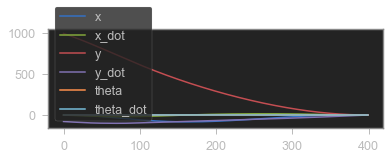

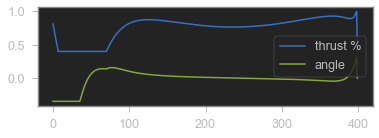

0.04
16.0


In [5]:
plt.subplot(211)
plt.plot(sol.value(x)[:, 0], label = "x")
plt.plot(sol.value(x)[:, 1], label = "x_dot")
plt.plot(sol.value(x)[:, 2], label = "y")
plt.plot(sol.value(x)[:, 3], label = "y_dot")
plt.plot(sol.value(x)[:, 4], label = "theta")
plt.plot(sol.value(x)[:, 5], label = "theta_dot")
plt.legend()
plt.show()

# Plot control input
plt.subplot(212)
plt.plot(sol.value(u)[:, 0], label = "thrust %")
plt.plot(sol.value(u)[:, 1], label = "angle")
plt.legend()
plt.show()

final_time_step = sol.value(t_step);
duration = sol.value(t_step) * steps

print(sol.value(t_step))
print(sol.value(t_step * steps))

Generating Animation


IntProgress(value=0, max=400)

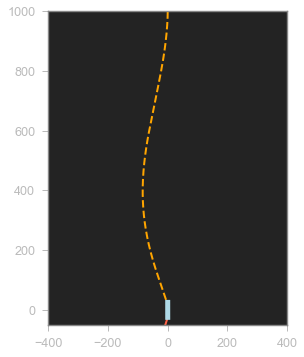

In [6]:
print("Generating Animation")
f = IntProgress(min = 0, max = steps)
display(f)

x_t = sol.value(x)
u_t = sol.value(u)

fig = plt.figure(figsize = (5, 5), constrained_layout=False)

ax1 = fig.add_subplot(111)

ln6, = ax1.plot([], [], '--', linewidth = 2, color = 'orange')

ln2, = ax1.plot([], [], linewidth = 2, color = 'tomato')
ln1, = ax1.plot([], [], linewidth = 5, color = 'lightblue')

#plt.axis('off')
plt.tight_layout()

ax1.set_xlim(-400, 400)
ax1.set_ylim(-50, 1000)
ax1.set_aspect(1)

def update(i):
  rocket_theta = x_t[i, 4]

  rocket_x = x_t[i, 0]
  rocket_x_points = [rocket_x + length/2 * sin(rocket_theta), rocket_x - length/2 * sin(rocket_theta)]

  rocket_y = x_t[i, 2]
  rocket_y_points = [rocket_y + length/2 * cos(rocket_theta), rocket_y - length/2 * cos(rocket_theta)]

  ln1.set_data(rocket_x_points, rocket_y_points)


  thrust_mag = u_t[i, 0]
  thrust_angle = -u_t[i, 1]

  flame_length = (thrust_mag) * 50


  flame_x_points = [rocket_x_points[1], rocket_x_points[1] + flame_length * sin(thrust_angle - rocket_theta)]
  flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * cos(thrust_angle - rocket_theta)]

  ln2.set_data(flame_x_points, flame_y_points)

  ln6.set_data(x_t[:i, 0], x_t[:i, 2])

  f.value += 1

anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * 1000)

anim